# Notebook 02 — Feature Engineering & Signal Design

In Notebook 01 we explored the raw screener snapshots stored in DuckDB.

This notebook focuses on **turning those raw columns into usable trading features**:

- Normalize Day % moves by recent volatility  
- Detect volatility regimes (quiet / normal / hot)  
- Measure short-term trend and choppiness per ticker  
- Bucket names by edge / liquidity for position sizing  

All feature engineering is done **in DuckDB using SQL window functions**, so this notebook
also showcases SQL skills. The resulting features are stored in a new table:

`data/volatility_alpha.duckdb :: screener_features`

These features will feed into:

- future backtesting notebooks  
- an RL environment for the Volatility Alpha Engine  
- UI ideas (e.g., filters like “high edge + high vol regime”)

## 1. Imports and connect to DuckDB

We re-use the same DuckDB database created by the Streamlit screener.

In [1]:
import duckdb
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Consistent chart size
plt.rcParams["figure.figsize"] = (10, 6)

# Path: notebooks/ -> .. -> data/volatility_alpha.duckdb
DB_PATH = (Path.cwd().parent / "data" / "volatility_alpha.duckdb").as_posix()

# --- Safe reconnect logic ---
# If a DuckDB connection named `con` already exists, close it first
if "con" in globals():
    try:
        con.close() # type: ignore
    except Exception:
        pass

# Open a fresh connection
con = duckdb.connect(DB_PATH)

# Quick sanity check: list tables
con.sql("SHOW TABLES;").df()

,name
0,screener_features
1,screener_returns
2,screener_returns_with_target
3,screener_signals
4,screener_snapshots


## 2. Quick recap of `screener_snapshots`

We confirm the raw structure before engineering new features.

In [2]:
raw_sample = con.sql("""
    SELECT *
    FROM screener_snapshots
    ORDER BY run_date DESC, ticker
    LIMIT 10;
""").df()

raw_sample

,run_date,ticker,last_price,day_pct,volume,rv_20d,rv_60d,edge_score,nearest_exp
0,2025-12-01,AMD,215.660004,-0.859649,3312950.0,68.691670,74.422502,34.775660,None
1,2025-12-01,NVDA,176.332199,-0.377289,22401443.0,41.973659,38.081710,21.175474,None
2,2025-12-01,QQQ,613.349976,-0.952769,5581522.0,21.501747,17.302496,11.227258,None
3,2025-12-01,SPY,679.200012,-0.613120,4587375.0,14.996082,12.424457,7.804601,None
4,2025-12-01,TSLA,427.679993,-0.578846,6627841.0,53.373477,51.377442,26.976161,None
5,2025-11-30,AMD,217.529999,1.535658,18658000.0,68.691670,74.422502,35.113664,None
6,2025-11-30,NVDA,177.000000,-1.808496,121332800.0,41.973659,38.081710,21.891077,None
7,2025-11-30,QQQ,619.250000,0.810715,23034400.0,21.501747,17.302496,11.156231,None
8,2025-11-30,SPY,683.390015,0.545848,49212000.0,14.996082,12.424457,7.770965,None
9,2025-11-30,TSLA,430.170013,0.841584,36252900.0,53.373477,51.377442,27.107530,None


In [3]:
con.sql("""
    SELECT
        COUNT(*)        AS num_rows,
        COUNT(DISTINCT ticker) AS num_tickers,
        MIN(run_date)   AS min_date,
        MAX(run_date)   AS max_date
    FROM screener_snapshots;
""").df()

,num_rows,num_tickers,min_date,max_date
0,10,5,2025-11-30,2025-12-01


## 3. Feature design

We will create a new table `screener_features` with the following extra columns:

**Volatility & move-based features**
- `move_vs_rv20` – Day % move divided by RV 20d  
- `rv_trend` – RV 20d minus RV 60d (positive = vol picking up)  

**Rolling behaviour (per ticker)**
- `day_pct_ma_5` – 5-day rolling mean of Day %  
- `day_pct_vol_5` – 5-day rolling std dev of Day %  

**Buckets / regimes**
- `vol_regime` – {`low`, `normal`, `high`} based on RV 20d thresholds  
- `edge_bucket` – {`quiet`, `active`, `hot`} based on edge_score  
- `liquidity_bucket` – {`thin`, `medium`, `thick`} based on volume  

All of this will be computed using **DuckDB SQL window functions** and written into a new table.

### Threshold definitions

To keep the logic transparent, here are the cutoffs we use:

**Volatility Regime (RV 20d):**
- `< 20%`  → `low`
- `20–40%` → `normal`
- `> 40%`  → `high`

**Edge Buckets (edge_score):**
- `< 10`   → `quiet`
- `10–25`  → `active`
- `> 25`   → `hot`

**Liquidity Buckets (volume):**
- `< 1,000,000`        → `thin`
- `1,000,000–10,000,000` → `medium`
- `> 10,000,000`       → `thick`

These are simple V1 cutoffs we can tune later based on backtest results.

## 4. Create the `screener_features` table

We use a single SQL statement to build the engineered features and store them
in a new DuckDB table. This can be re-run any time new snapshots are added.

In [4]:
con.sql("""
CREATE OR REPLACE TABLE screener_features AS
SELECT
    -- core identifiers
    run_date,
    ticker,

    -- raw inputs
    last_price,
    day_pct,
    volume,
    rv_20d,
    rv_60d,
    edge_score,
    nearest_exp,

    -- 1) move normalized by recent vol (avoid divide-by-zero)
    CASE
        WHEN rv_20d IS NULL OR rv_20d = 0 THEN NULL
        ELSE day_pct / rv_20d
    END AS move_vs_rv20,

    -- 2) realized volatility trend (short minus long)
    (rv_20d - rv_60d) AS rv_trend,

    -- 3) 5-day rolling mean of Day % per ticker
    AVG(day_pct) OVER (
        PARTITION BY ticker
        ORDER BY run_date
        ROWS BETWEEN 4 PRECEDING AND CURRENT ROW
    ) AS day_pct_ma_5,

    -- 4) 5-day rolling std dev of Day % per ticker
    STDDEV(day_pct) OVER (
        PARTITION BY ticker
        ORDER BY run_date
        ROWS BETWEEN 4 PRECEDING AND CURRENT ROW
    ) AS day_pct_vol_5,

    -- 5) volatility regime based on RV 20d
    CASE
        WHEN rv_20d IS NULL THEN 'unknown'
        WHEN rv_20d < 20 THEN 'low'
        WHEN rv_20d < 40 THEN 'normal'
        ELSE 'high'
    END AS vol_regime,

    -- 6) edge bucket (how "exciting" today is)
    CASE
        WHEN edge_score IS NULL THEN 'unknown'
        WHEN edge_score < 10 THEN 'quiet'
        WHEN edge_score < 25 THEN 'active'
        ELSE 'hot'
    END AS edge_bucket,

    -- 7) liquidity bucket based on volume
    CASE
        WHEN volume IS NULL THEN 'unknown'
        WHEN volume < 1e6 THEN 'thin'
        WHEN volume < 1e7 THEN 'medium'
        ELSE 'thick'
    END AS liquidity_bucket

FROM screener_snapshots;
""")

con.sql("SHOW TABLES;").df()

,name
0,screener_features
1,screener_returns
2,screener_returns_with_target
3,screener_signals
4,screener_snapshots


## 5. Inspect the engineered feature table

We sanity-check that the new columns look reasonable.

In [5]:
feat_sample = con.sql("""
    SELECT *
    FROM screener_features
    ORDER BY run_date DESC, ticker
    LIMIT 10;
""").df()

feat_sample

,run_date,ticker,last_price,day_pct,volume,rv_20d,rv_60d,edge_score,nearest_exp,move_vs_rv20,rv_trend,day_pct_ma_5,day_pct_vol_5,vol_regime,edge_bucket,liquidity_bucket
0,2025-12-01,AMD,215.660004,-0.859649,3312950.0,68.691670,74.422502,34.775660,None,-0.012515,-5.730832,0.338004,1.693738,high,hot,medium
1,2025-12-01,NVDA,176.332199,-0.377289,22401443.0,41.973659,38.081710,21.175474,None,-0.008989,3.891949,-1.092892,1.012016,high,active,thick
2,2025-12-01,QQQ,613.349976,-0.952769,5581522.0,21.501747,17.302496,11.227258,None,-0.044311,4.199251,-0.071027,1.246972,normal,active,medium
3,2025-12-01,SPY,679.200012,-0.613120,4587375.0,14.996082,12.424457,7.804601,None,-0.040885,2.571625,-0.033636,0.819515,low,quiet,medium
4,2025-12-01,TSLA,427.679993,-0.578846,6627841.0,53.373477,51.377442,26.976161,None,-0.010845,1.996035,0.131369,1.004395,high,hot,medium
5,2025-11-30,AMD,217.529999,1.535658,18658000.0,68.691670,74.422502,35.113664,None,0.022356,-5.730832,1.535658,NaN,high,hot,thick
6,2025-11-30,NVDA,177.000000,-1.808496,121332800.0,41.973659,38.081710,21.891077,None,-0.043086,3.891949,-1.808496,NaN,high,active,thick
7,2025-11-30,QQQ,619.250000,0.810715,23034400.0,21.501747,17.302496,11.156231,None,0.037705,4.199251,0.810715,NaN,normal,active,thick
8,2025-11-30,SPY,683.390015,0.545848,49212000.0,14.996082,12.424457,7.770965,None,0.036399,2.571625,0.545848,NaN,low,quiet,thick
9,2025-11-30,TSLA,430.170013,0.841584,36252900.0,53.373477,51.377442,27.107530,None,0.015768,1.996035,0.841584,NaN,high,hot,thick


In [6]:
con.sql("""
    SELECT
        vol_regime,
        edge_bucket,
        liquidity_bucket,
        COUNT(*) AS rows
    FROM screener_features
    GROUP BY 1,2,3
    ORDER BY rows DESC;
""").df()

,vol_regime,edge_bucket,liquidity_bucket,rows
0,high,hot,thick,2
1,high,hot,medium,2
2,high,active,thick,2
3,normal,active,thick,1
4,low,quiet,thick,1
5,low,quiet,medium,1
6,normal,active,medium,1


## 6. Simple EDA on engineered features

Even with a small sample, we can look at how some engineered features behave.
Once more days are loaded, these plots become more informative.

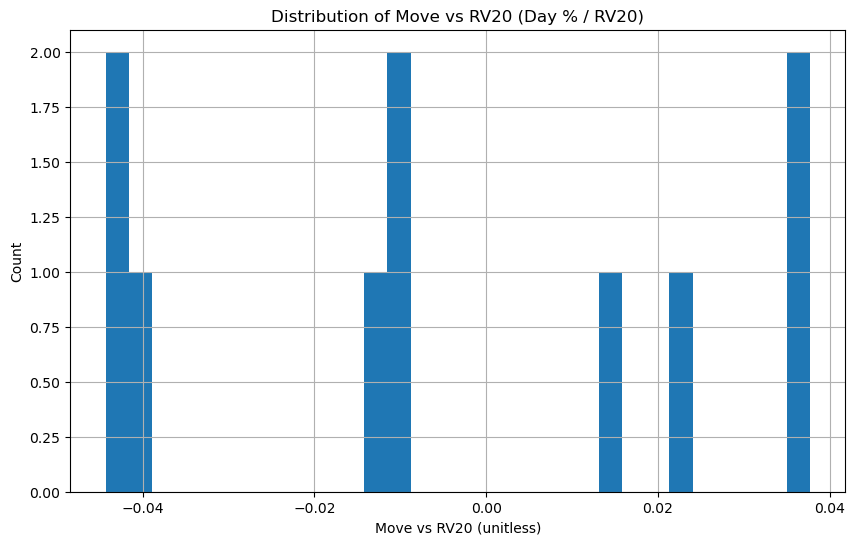

In [7]:
# Distribution of move_vs_rv20

features_df = con.sql("""
    SELECT *
    FROM screener_features;
""").df()

features_df = features_df.replace([float("inf"), float("-inf")], pd.NA)

mv_clean = features_df["move_vs_rv20"].dropna()
if not mv_clean.empty:
    mv_clean.hist(bins=30)
    plt.title("Distribution of Move vs RV20 (Day % / RV20)")
    plt.xlabel("Move vs RV20 (unitless)")
    plt.ylabel("Count")
    plt.show()
else:
    print("Not enough data yet to plot move_vs_rv20.")

**Reading this plot:**  
Right now the distribution is thin because we only have a small sample.  
As more days are loaded, we expect most values to cluster near 0 (small moves vs recent vol)  
with occasional outliers where today’s move is unusually large relative to RV20.

In [8]:
# Edge bucket vs volatility regime

pivot = con.sql("""
    SELECT
        vol_regime,
        edge_bucket,
        COUNT(*) AS cnt
    FROM screener_features
    GROUP BY 1,2
    ORDER BY 1,2;
""").df()

pivot

,vol_regime,edge_bucket,cnt
0,high,active,2
1,high,hot,4
2,low,quiet,2
3,normal,active,2


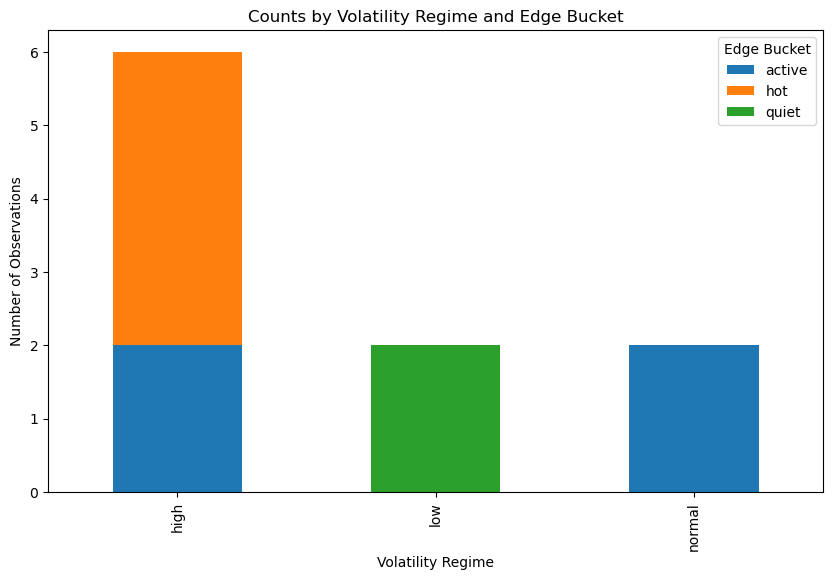

In [9]:
if not pivot.empty:
    pivot_pivot = pivot.pivot(index="vol_regime", columns="edge_bucket", values="cnt").fillna(0)
    pivot_pivot.plot(kind="bar", stacked=True)
    plt.title("Counts by Volatility Regime and Edge Bucket")
    plt.xlabel("Volatility Regime")
    plt.ylabel("Number of Observations")
    plt.legend(title="Edge Bucket")
    plt.show()

**Reading this plot:**  
This chart shows how often different volatility regimes (`low`/`normal`/`high`)  
coincide with different edge buckets (`quiet`/`active`/`hot`).  
With more history, this will tell us whether high-volatility environments tend  
to produce more “hot” edge days and where most of our potential trades live.

### 6.3 Example: 5-day rolling behaviour for one ticker

Here we look at a single ticker to see how the rolling mean and volatility of Day % evolve.
With more data, this becomes a nice way to identify trending vs choppy periods.

In [10]:
example_ticker = features_df["ticker"].dropna().unique()[0]
example = features_df[features_df["ticker"] == example_ticker].copy()
example = example.sort_values("run_date")

example[["run_date", "day_pct", "day_pct_ma_5", "day_pct_vol_5"]]

,run_date,day_pct,day_pct_ma_5,day_pct_vol_5
0,2025-11-30,-1.808496,-1.808496,NaN
1,2025-12-01,-0.377289,-1.092892,1.012016


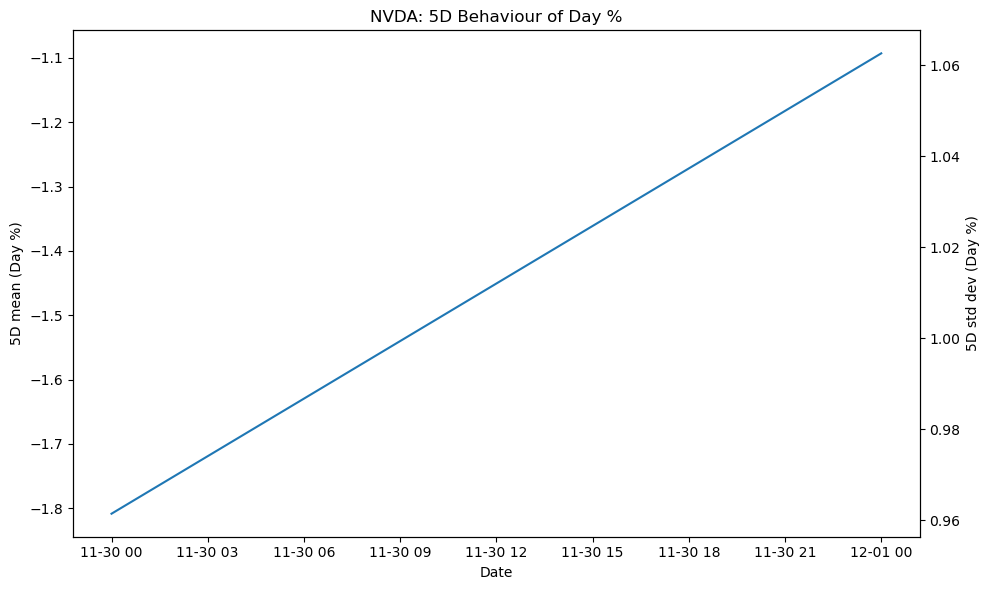

In [11]:
if len(example) > 1:
    fig, ax1 = plt.subplots()

    ax1.plot(example["run_date"], example["day_pct_ma_5"], label="5D mean of Day %")
    ax1.set_ylabel("5D mean (Day %)")
    ax1.set_xlabel("Date")

    ax2 = ax1.twinx()
    ax2.plot(example["run_date"], example["day_pct_vol_5"], color="orange", label="5D vol of Day %") # type: ignore
    ax2.set_ylabel("5D std dev (Day %)")

    plt.title(f"{example_ticker}: 5D Behaviour of Day %")
    fig.tight_layout()
    plt.show()
else:
    print("Not enough history yet to show rolling behaviour.")

**Reading this plot:**  
The 5-day rolling mean of Day % captures short-term trend,  
while the 5-day rolling volatility captures choppiness.  
In a richer dataset, rising mean with falling volatility would point to  
clean trends; flat mean with high volatility would indicate noisy conditions.

In [12]:
con.close()

### Close connection

We close the DuckDB connection so other notebooks and apps can safely write to the database.

## 7. How these features feed RL & backtesting

Now that we have `screener_features`, we effectively have a **feature store**
for each (date, ticker) pair:

- `move_vs_rv20` tells us how big today's move is relative to recent realized vol  
- `rv_trend` captures whether volatility is picking up or calming down  
- `day_pct_ma_5` and `day_pct_vol_5` describe short-term trend and choppiness  
- `vol_regime`, `edge_bucket`, and `liquidity_bucket` provide clean filters  

These can be used to:

1. **Backtest simple rules**, e.g.  
   - only trade tickers in `high` vol regime with `hot` edge_bucket  
   - size down in `thin` liquidity_bucket  

2. **Define the RL state space**, e.g.  
   - state = [move_vs_rv20, rv_trend, day_pct_ma_5, day_pct_vol_5, one-hot(vol_regime), one-hot(edge_bucket)]

In later notebooks we will:

- sample sequences of these features per ticker  
- attach rewards based on future returns or PnL  
- train and evaluate policy ideas.

For now, this notebook establishes a **reusable, SQL-backed feature table** (`screener_features`) that
the rest of the Volatility Alpha Engine can build on.